In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

# 1. Basic parameters and color setup
dimensiune_grid = (10, 10)  # 10x10 grid
culori = [
    "red", "blue", "green", "yellow",
    "purple", "orange", "pink", "cyan",
    "brown", "lime"
]

# Observed color sequence
observatii = ['red', 'red', 'lime', 'yellow', 'blue']

# We'll create two dictionaries to map color <-> index
culoare_to_idx = {c: i for i, c in enumerate(culori)}
idx_to_culoare = {i: c for c, i in culoare_to_idx.items()}

# Convert the observations (string colors) into indices
observatii_idx = np.array([culoare_to_idx[c] for c in observatii]).reshape(-1, 1)
print("Observations (as indices):", observatii_idx.flatten())


Observations (as indices): [0 0 9 3 1]


In [24]:
# 2. Read the grid of colors from CSV
df = pd.read_csv('grid_culori.csv', header=None)  # adjust 'header=None' if needed
grid_culori = df.to_numpy()  # This will be a 10x10 array of color names

# Just to confirm the shape and check a few entries:
print("Shape of grid_culori:", grid_culori.shape)
print(grid_culori[0, :5])  # First row, first 5 columns


Shape of grid_culori: (10, 10)
['green' 'red' 'purple' 'brown' 'blue']


In [25]:
# 3. Create all possible states (i, j) for i in [0..9], j in [0..9]
stari_ascunse = [(i, j) for i in range(dimensiune_grid[0])
                         for j in range(dimensiune_grid[1])]

numar_stari = len(stari_ascunse)  # should be 100
print("Number of states:", numar_stari)

# Build dictionaries to map (i, j) <-> state index
stare_to_idx = {stare: idx for idx, stare in enumerate(stari_ascunse)}
idx_to_stare = {idx: stare for stare, idx in stare_to_idx.items()}


Number of states: 100


In [26]:
def build_transition_matrix_remain_in_place(dim=(10,10), p_stay=0.25):
    """
    Returns the transition matrix for the specified grid size, where
    each cell has probability p_stay of remaining in place,
    and the rest is evenly distributed among its valid neighbors.
    """
    N = dim[0] * dim[1]  # total states
    trans = np.zeros((N, N))

    for i in range(dim[0]):
        for j in range(dim[1]):
            current_state = stare_to_idx[(i, j)]

            # Potential neighbors (up, down, left, right)
            neighbors = []
            if i - 1 >= 0:
                neighbors.append((i - 1, j))
            if i + 1 < dim[0]:
                neighbors.append((i + 1, j))
            if j - 1 >= 0:
                neighbors.append((i, j - 1))
            if j + 1 < dim[1]:
                neighbors.append((i, j + 1))

            num_neighbors = len(neighbors)

            # Probability to stay in place
            trans[current_state, current_state] = p_stay

            # Probability distributed among neighbors
            if num_neighbors > 0:
                move_prob = (1.0 - p_stay) / num_neighbors
                for nb in neighbors:
                    nb_state = stare_to_idx[nb]
                    trans[current_state, nb_state] = move_prob

    return trans

# Build the matrix with 25% remain in place
trans_mat_remain = build_transition_matrix_remain_in_place(dimensiune_grid, p_stay=0.25)
print("Transition matrix shape:", trans_mat_remain.shape)


Transition matrix shape: (100, 100)


In [27]:
def build_emission_matrix(grid, colors):
    """
    grid: 10x10 array of color names (strings)
    colors: list of all possible color names in order
    Returns emission probability matrix of shape [num_states, num_observations].
    """
    N = grid.shape[0] * grid.shape[1]  # total states = 100
    M = len(colors)                    # number of possible color observations
    emission = np.zeros((N, M))

    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            state_idx = stare_to_idx[(i, j)]
            color_name = grid[i, j]
            color_idx = culoare_to_idx[color_name]
            # Probability 1 for the color in this cell, 0 for others
            emission[state_idx, color_idx] = 1.0

    return emission

emission_mat = build_emission_matrix(grid_culori, culori)
print("Emission matrix shape:", emission_mat.shape)


Emission matrix shape: (100, 10)


In [28]:
# Number of hidden states
n_states = numar_stari
# Number of possible observation symbols
n_observations = len(culori)

# Create the model
model_remain = hmm.CategoricalHMM(n_components=n_states, init_params="", n_iter=1)

# Start probabilities (uniform, since the agent is placed randomly)
model_remain.startprob_ = np.full(n_states, 1.0 / n_states)

# Transition probabilities
model_remain.transmat_ = trans_mat_remain

# Emission probabilities
model_remain.emissionprob_ = emission_mat

# Use the Viterbi algorithm to decode the most likely state sequence
logprob, state_sequence = model_remain.decode(observatii_idx, algorithm="viterbi")

# Convert log probability to actual probability
path_probability = np.exp(logprob)

print("Most likely state sequence (indices):", state_sequence)
print("Log Probability of this sequence:", logprob)
print("Probability of this sequence:", path_probability)

# If you want to see the (i, j) positions:
drum = [idx_to_stare[idx] for idx in state_sequence]
print("Most likely path (row, col):", drum)


Most likely state sequence (indices): [70 70 71 72 82]
Log Probability of this sequence: -10.725711775371217
Probability of this sequence: 2.1972656249999982e-05
Most likely path (row, col): [(7, 0), (7, 0), (7, 1), (7, 2), (8, 2)]


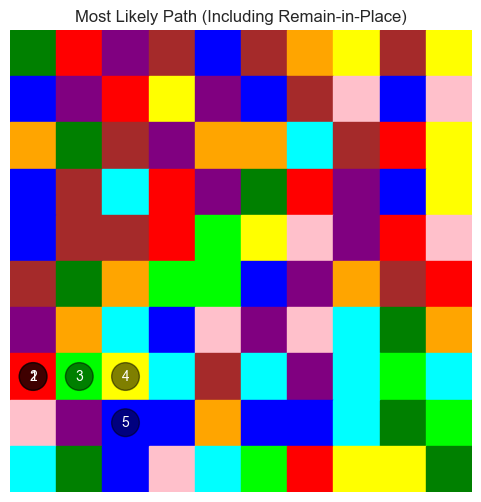

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the colored grid
for i in range(dimensiune_grid[0]):
    for j in range(dimensiune_grid[1]):
        cell_color = grid_culori[i, j]
        ax.add_patch(plt.Rectangle((j, dimensiune_grid[0] - i - 1), 1, 1, color=cell_color))

# Overlay the path
for idx, (row, col) in enumerate(drum):
    # Mark the center of each cell
    x = col + 0.5
    y = dimensiune_grid[0] - row - 0.5
    ax.add_patch(plt.Circle((x, y), 0.3, color="black", alpha=0.5))
    ax.text(x, y, str(idx + 1), color="white", ha="center", va="center", fontsize=10)

ax.set_xlim(0, dimensiune_grid[1])
ax.set_ylim(0, dimensiune_grid[0])
ax.set_aspect("equal")
ax.axis("off")
plt.title("Most Likely Path (Including Remain-in-Place)")
plt.show()
